In [1]:
from __future__ import division
import numpy as np
import ciw
import math
import yaml
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm_notebook
sns.set_style('whitegrid')
%matplotlib inline

In [45]:
def mean_time_deadlock_sim(n, m, r11, L, schedule_lengths):
    s, sv = schedule_lengths[0], schedule_lengths[1]
    params = {
        'Arrival_distributions': [['Exponential', L]],
        'Service_distributions': [['Exponential', m]],
        'Transition_matrices': [[r11]],
        'schedule_vacations': ([[s, 1], [s + sv, 0]], True),
        'Number_of_servers': ['schedule_vacations'],
        'Queue_capacities': [n]
    }
    times = []
    for i in range(10000):
        N = ciw.create_network(params)
        Q = ciw.Simulation(N, deadlock_detector='StateDigraph')
        Q.simulate_until_deadlock()
        times.append(Q.times_to_deadlock[((0, 0),)])
    return times

In [3]:
class NetworkP:
    """
    A class to hold the queueing network object
    """

    def __init__(self, n1, mu1, r11, L1):
        """
        Initialises the Network object
        """
        self.n1 = n1
        self.mu1 = mu1
        self.r11 = r11
        self.L1 = L1
        self.State_Space = [(i) for i in range(self.n1+2)] + [-1]
        self.write_transition_matrix()
        self.discretise_transition_matrix()

    def find_transition_rates(self, state1, state2):
        """
        Finds the transition rates for given state transition

        """
        if state1 == -1:
            return 0
        if state2 == -1:
            if state1 == self.n1 + 1:
                return self.r11*self.mu1
            else:
                return 0
        else:
            delta = (state2-state1)
            if delta == 1:
                if state1<self.n1+1:
                    return self.L1
                return 0
            if delta == -1:
                return (1-self.r11)*self.mu1
        return 0

    def write_transition_matrix(self):
        """
        Writes the transition matrix for the markov chain
        """
        self.transition_matrix = [[self.find_transition_rates(s1, s2) for s2 in self.State_Space] for s1 in self.State_Space]
        for i in range(len(self.transition_matrix)):
            a = sum(self.transition_matrix[i])
            self.transition_matrix[i][i] = -a
            self.transition_matrix = np.array(self.transition_matrix)
            
    def get_time_step_upper_bound(self):
        return 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        

    def discretise_transition_matrix(self, time_step=None):
        """
        Disctetises the transition matrix
        """
        if time_step is None:
            self.time_step = 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        else:
            self.time_step = time_step
        self.discrete_transition_matrix = self.transition_matrix*self.time_step + np.identity(len(self.transition_matrix))

        
class NetworkPv:
    """
    A class to hold the queueing network object
    """

    def __init__(self, n1, mu1, r11, L1):
        """
        Initialises the Network object
        """
        self.n1 = n1
        self.mu1 = mu1
        self.r11 = r11
        self.L1 = L1
        self.State_Space = [(i) for i in range(self.n1+2)] + [-1]
        self.write_transition_matrix()
        self.discretise_transition_matrix()

    def find_transition_rates(self, state1, state2):
        """
        Finds the transition rates for given state transition

        """
        if state1 == -1:
            return 0
        if state2 == -1:
            if state1 == self.n1 + 1:
                return self.r11*self.mu1
            else:
                return 0
        else:
            delta = (state2-state1)
            if delta == 1:
                if state1<self.n1:
                    return self.L1
                return 0
            if delta == -1:
                return (1-self.r11)*self.mu1
        return 0

    def write_transition_matrix(self):
        """
        Writes the transition matrix for the markov chain
        """
        self.transition_matrix = [[self.find_transition_rates(s1, s2) for s2 in self.State_Space] for s1 in self.State_Space]
        for i in range(len(self.transition_matrix)):
            a = sum(self.transition_matrix[i])
            self.transition_matrix[i][i] = -a
            self.transition_matrix = np.array(self.transition_matrix)
            
    def get_time_step_upper_bound(self):
        return 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        

    def discretise_transition_matrix(self, time_step=None):
        """
        Disctetises the transition matrix
        """
        if time_step is None:
            self.time_step = 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        else:
            self.time_step = time_step
        self.discrete_transition_matrix = self.transition_matrix*self.time_step + np.identity(len(self.transition_matrix))


        
        
def find_time_step(schedule_lengths, upper_bound):
    """
    schedule_lengths: tuple of the form (length1, length2)
    upper_bound: the upper bound of the time step size
    """    
    d = math.gcd(*schedule_lengths)
    delta = d / math.ceil(d/upper_bound)
    discrete_schedule_lengths = [s / delta for s in schedule_lengths]
    return delta, discrete_schedule_lengths

In [4]:
def obtain_transition_matrices(n, mu, r11, L, schedule_lengths):
    N, Nv = NetworkP(n, mu, r11, L), NetworkPv(n, 0, r11, L)
    upper_bound = N.get_time_step_upper_bound()
    delta, discrete_schedule_lengths = find_time_step(schedule_lengths, upper_bound)
    
    N.discretise_transition_matrix(time_step=delta)
    P = N.discrete_transition_matrix
    
    Nv.discretise_transition_matrix(delta)
    Pv = Nv.discrete_transition_matrix
    

    return P, Pv, discrete_schedule_lengths, delta

In [5]:
def obtain_probability_distributions(n, mu, r11, L, schedule_lengths, stopping_probability = .9999):
    P, Pv, discrete_schedule_lengths, delta = obtain_transition_matrices(n, mu, r11, L, schedule_lengths)
    
    step_counts = [0, 1]
    approx_cdf = [0, P[0, -1]]
    approx_pdf = [0, P[0, -1]]
    transition_matrix = P
    step = 1
    
    while approx_cdf[-1] < stopping_probability:
        step += 1
        if step % sum(discrete_schedule_lengths) < discrete_schedule_lengths[0]:
            transition_matrix = np.matmul(transition_matrix, P)
        else:
            transition_matrix = np.matmul(transition_matrix, Pv)
        step_counts.append(step)
        absorption_prob = transition_matrix[0, -1]
        approx_cdf.append(absorption_prob)
        approx_pdf.append(approx_cdf[-1] - approx_cdf[-2])
    
    pdf = [p / sum(approx_pdf) for p in approx_pdf]
    cdf = np.cumsum(pdf)
    time_steps = [s * delta for s in step_counts]
    return time_steps, pdf, cdf

In [6]:
def mean_time_till_deadlock(n, mu, r11, L, schedule_lengths, stopping_probability = .9999):
    time_steps, pdf, cdf = obtain_probability_distributions(n, mu, r11, L, schedule_lengths, stopping_probability = .9999)
    return sum([step * prob for step, prob in zip(time_steps, pdf)])

In [7]:
L = 5.0
m = 2.0
n = 3
r11 = 0.5
s = 10
sv = 5

In [56]:
ns = [0, 1, 2, 3, 4, 5, 6]

In [57]:
anal_times = [mean_time_till_deadlock(n, m, r11, L, (s, sv)) for n in ns]

In [58]:
sim_times = [mean_time_deadlock_sim(n, m, r11, L, (s, sv)) for n in tqdm_notebook(ns)]

In [59]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
sns.set(style="whitegrid")

In [60]:
times_no_outliers = []
for data_series in sim_times:
    q75, q25 = np.percentile(data_series, [75 ,25])
    iqr = q75 - q25
    upper = q75 + (1.5*iqr)
    lower = q25 - (1.5*iqr)
    new_data = [obs for obs in data_series if obs > lower and obs < upper]
    times_no_outliers.append(new_data)

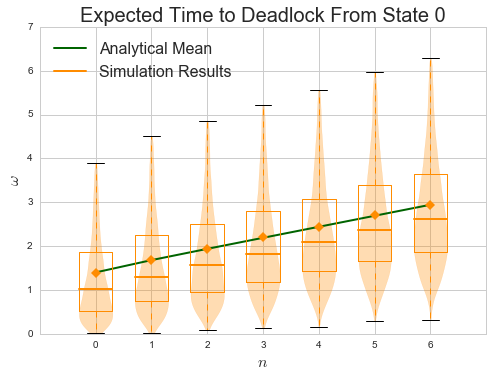

In [66]:
line_colour = 'darkgreen'
plot_colour = 'darkorange'

fig, ax = plt.subplots()
plt.plot(ns, anal_times, linewidth=2, label='Analytical Mean', color=line_colour)
plt.plot([], [], 'r', linewidth=2, label='Simulation Results', color=plot_colour)
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor=plot_colour)
bp = plt.boxplot(sim_times, positions=ns, widths=0.6, meanprops=meanpointprops, meanline=False, showmeans=True, sym='')
for median in bp['medians']:
    median.set(color=plot_colour, linewidth=2)
pylab.setp(bp['boxes'], color=plot_colour)
pylab.setp(bp['whiskers'], color=plot_colour)


vp = plt.violinplot(times_no_outliers, widths=0.6, positions=ns, showmeans=False, showmedians=False, showextrema=False)
pylab.setp(vp['bodies'], color=plot_colour)
plt.xlim([min(ns)-1, max(ns)+1])
ax.set_xlabel(r'$n$', fontsize=16)
ax.set_ylabel(r'$\omega$', fontsize=16)
ax.set_title('Expected Time to Deadlock From State 0', fontsize=20)

plt.legend(loc=2, prop={'size':16})
plt.savefig('tex/img/mc_sim_vary_n_scheduled_vacations.pdf')